In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your stock data from "ETHUSDT_MinuteBars.csv"
data = pd.read_csv('ETHUSDT_MinuteBars.csv')

# Extract relevant features (open, high, low, volume)
features = ['open', 'high', 'low', 'volume']
data = data[features + ['close']]

# Include yesterday's data and today's open price as features
data['yesterday_high'] = data['high'].shift(1)
data['yesterday_low'] = data['low'].shift(1)
data['yesterday_volume'] = data['volume'].shift(1)
data['yesterday_open'] = data['open'].shift(1)
data['yesterday_close'] = data['close'].shift(1)
data['today_open'] = data['open']

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define the number of time steps for the model
n_steps = 60



In [2]:
data

,open,high,low,volume,close,yesterday_high,yesterday_low,yesterday_volume,yesterday_open,yesterday_close,today_open
0,1605.24,1605.97,1604.47,678.2426,1605.75,NaN,NaN,NaN,NaN,NaN,1605.24
1,1605.75,1605.75,1604.62,505.8784,1604.90,1605.97,1604.47,678.2426,1605.24,1605.75,1605.75
2,1604.90,1605.19,1604.36,541.4028,1605.00,1605.75,1604.62,505.8784,1605.75,1604.90,1604.90
3,1605.00,1605.19,1604.77,477.3287,1604.97,1605.19,1604.36,541.4028,1604.90,1605.00,1605.00
4,1604.98,1605.18,1604.97,171.9733,1605.18,1605.19,1604.77,477.3287,1605.00,1604.97,1604.98
...,...,...,...,...,...,...,...,...,...,...,...
294692,1586.41,1586.42,1586.39,51.0535,1586.40,1586.49,1586.06,43.3341,1586.06,1586.42,1586.41
294693,1586.40,1587.04,1586.39,136.0542,1587.04,1586.42,1586.39,51.0535,1586.41,1586.40,1586.40
294694,1587.04,1587.04,1586.39,117.7711,1586.39,1587.04,1586.39,136.0542,1586.40,1587.04,1587.04
294695,1586.39,1586.63,1586.39,26.1817,1586.63,1587.04,1586.39,117.7711,1587.04,1586.39,1586.39


In [3]:
data.drop(['open','high','low','volume'],axis = 1,inplace=True)

In [4]:
data.drop(0,inplace=True)

In [5]:
data

,close,yesterday_high,yesterday_low,yesterday_volume,yesterday_open,yesterday_close,today_open
1,1604.90,1605.97,1604.47,678.2426,1605.24,1605.75,1605.75
2,1605.00,1605.75,1604.62,505.8784,1605.75,1604.90,1604.90
3,1604.97,1605.19,1604.36,541.4028,1604.90,1605.00,1605.00
4,1605.18,1605.19,1604.77,477.3287,1605.00,1604.97,1604.98
5,1604.96,1605.18,1604.97,171.9733,1604.98,1605.18,1605.17
...,...,...,...,...,...,...,...
294692,1586.40,1586.49,1586.06,43.3341,1586.06,1586.42,1586.41
294693,1587.04,1586.42,1586.39,51.0535,1586.41,1586.40,1586.40
294694,1586.39,1587.04,1586.39,136.0542,1586.40,1587.04,1587.04
294695,1586.63,1587.04,1586.39,117.7711,1587.04,1586.39,1586.39


In [6]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define the number of time steps for the model
n_steps = 60

# Create sequences of data for training
X, y = [], []

for i in range(n_steps, len(data_scaled)):
    X.append(data_scaled[i - n_steps:i,1:])  # Use all features except the last one (close)
    y.append(data_scaled[i, 0])  # Use the last feature (close)

X, y = np.array(X), np.array(y)



Epoch 1/2
7368/7368 [==============================] - 293s 39ms/step - loss: 1.4001e-04
Epoch 2/2
1840/1840 [==============================] - 26s 14ms/step
LSTM-GRU RMSE: 0.00


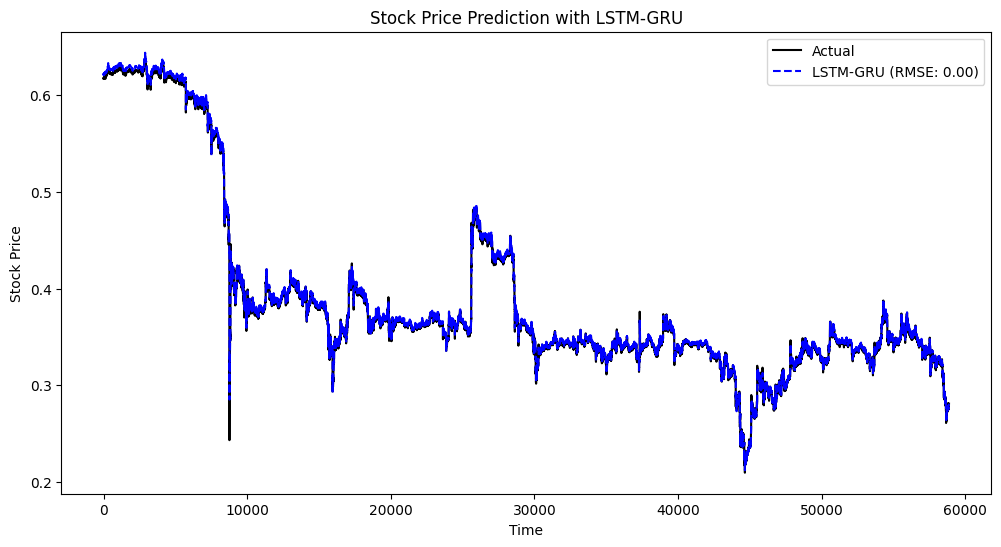

In [7]:
# Split the data into training and testing sets
train_size = int(0.8 * len(data_scaled))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the RNN model with LSTM and GRU layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)


# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"LSTM-GRU RMSE: {rmse:.2f}")

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='black')
plt.plot(y_pred, label=f'LSTM-GRU (RMSE: {rmse:.2f})', color='blue', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM-GRU')
plt.legend()
plt.show()


In [10]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool

# Create a Bokeh figure
p = figure(title='Stock Price Prediction with LSTM-GRU', x_axis_label='Time', y_axis_label='Stock Price',
           width=800, height=400)

# Convert range into a list for plotting
x_range = list(range(len(y_test)))

# Plot the actual data
p.line(x_range, y_test, line_color='black', legend_label='Actual')
# Plot the predicted data
p.line(x_range, y_pred.flatten(), line_color='blue', line_dash='dashed', legend_label=f'LSTM-GRU (RMSE: {rmse}')

# Add a hover tool to display values on hover
hover = HoverTool(tooltips=[("Index", "$index"), ("Actual", "@y_test"), ("Predicted", "@y_pred")])
p.add_tools(hover)

# Show the plot in a Jupyter Notebook
output_notebook()
show(p)


Loading BokehJS ...

LSTM-GRU RMSE: 1.99


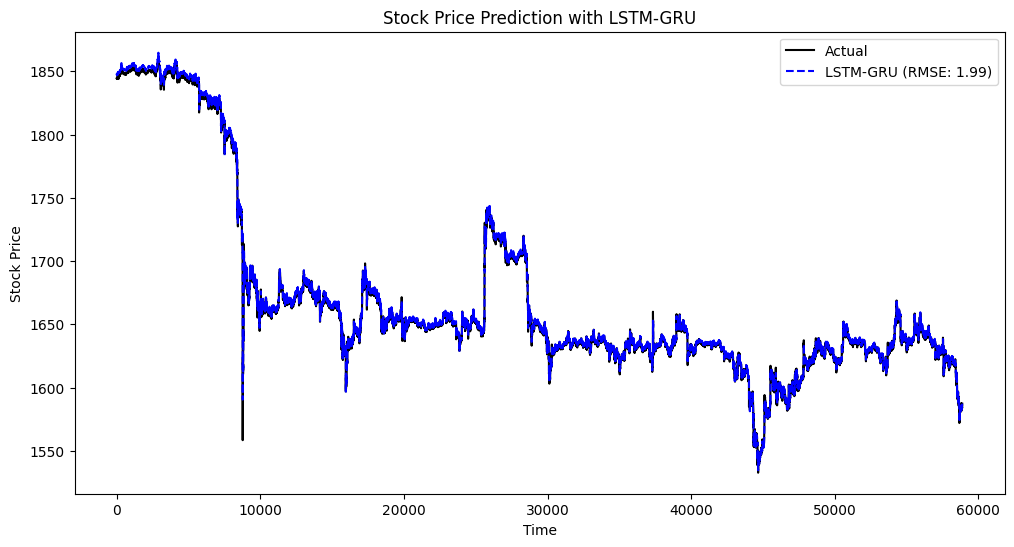

In [26]:
# Inverse transform the scaled predictions and true values using the original scaler
y_pred_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred.reshape(-1, 1)), axis=1))
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))

# Extract the last column (close prices) after inverse transform
y_pred_original = y_pred_original[:, -1]
y_test_original = y_test_original[:, -1]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"LSTM-GRU RMSE: {rmse:.2f}")

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', color='black')
plt.plot(y_pred_original, label=f'LSTM-GRU (RMSE: {rmse:.2f})', color='blue', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM-GRU')
plt.legend()
plt.show()




In [27]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool

# Create a Bokeh figure
p = figure(title='Stock Price Prediction with LSTM-GRU', x_axis_label='Time', y_axis_label='Stock Price',
           width=800, height=400)

# Convert range into a list for plotting
x_range = list(range(len(y_test)))

# Plot the actual data
p.line(x_range, y_test_original, line_color='black', legend_label='Actual')
# Plot the predicted data
p.line(x_range, y_pred_original.flatten(), line_color='blue', line_dash='dashed', legend_label=f'LSTM-GRU (RMSE: {rmse}')

# Add a hover tool to display values on hover
hover = HoverTool(tooltips=[("Index", "$index"), ("Actual", "@y_test"), ("Predicted", "@y_pred")])
p.add_tools(hover)

# Show the plot in a Jupyter Notebook
output_notebook()
show(p)


Loading BokehJS ...